## Load the imports
## Among the imported packages, PyNorm is a publicly available Python library designed for measuring absorption lines in astronomical spectra.

In [ ]:
import os
import pandas as pd
import asdf
import spectres
from ios import read_inorm
from aod import pyn_batch

In [ ]:
# The following is to know when this notebook has been run last time and with which python version.
import time, sys
import os
import pandas as pd
import dropbox
from dropbox import files
from dropbox.exceptions import AuthError
import asdf
import numpy as np
import pickle
os.sys.path.append('/afs/crc.nd.edu/user/s/sameer/pyNorm/pyNorm/')
import spectres
from ios import read_inorm
from aod import pyn_batch
from ios import myfuncpyNorm
from scipy.interpolate import interp1d
from itertools import combinations

from sklearn.metrics.pairwise import cosine_similarity

from scipy.signal import find_peaks
from itertools import combinations
from scipy.signal import argrelextrema, argrelmax
os.sys.path.append('/afs/crc.nd.edu/user/s/sameer/Research/LineFinder/Spectra/')
os.chdir('/afs/crc.nd.edu/user/s/sameer/Research/LineFinder/Spectra/')
from functions_pyALF import *

In [ ]:
def getdictsep(wave,flux,error,species,z):
    """
    
    This function is meant to create a dictionary consisting of keys that can be ingested by PyNorm. 
    Args:
        wave (array of floats): The observed wavelength array
        flux (array of floats): The normalized flux array
        error (array of floats): The array of errors associated with the normalized flux
        species (dict) : The dictionary comprising of information on atomic line data
        z (float): The redshift of the absorption system whose measurements are of interest.
    Returns:
        dict: A dictionary that can be ingested by PyNorm for performing line measurements.
    
    """
    
    dictionary = {}
    obs_wave = wave
    flux = flux
    error = error
    
    for specie in species:
        for transition in species[specie]:

            vel = getVel(obs_wave,species[specie][transition][0],z)
            #print (vel)
            
            vel_sel = np.where((vel<=4000) & (vel>=-4000))

            dictionary['{}_{}'.format(specie,transition)] = {'z':z,'vel':vel[vel_sel],'flux':flux[vel_sel],'eflux':error[vel_sel],
            'wavc':species[specie][transition][0],
            'fval':species[specie][transition][1],
            'contin':np.ones(len(vel[vel_sel])),
            'contin_err':np.zeros(len(vel[vel_sel]))}
            
    return dictionary


In [ ]:
def rebin_spectra(vel1, flux1, vel2, flux2, new_vel):
    """
    This function is meant to rebin a spectrum onto a common velocity axis.

    Args:
        vel1: velocity array of the first spectrum
        flux1: flux array of the first spectrum
        vel2: velocity array of the second spectrum
        flux2: flux array of the second spectrum        

    Returns:
        arrays: flux arrays of the first and second spectra.
    """
    
    interp_flux1 = interp1d(vel1, flux1, kind='linear', bounds_error=False, fill_value=np.nan)
    interp_flux2 = interp1d(vel2, flux2, kind='linear', bounds_error=False, fill_value=np.nan)

    new_flux1 = interp_flux1(new_vel)
    new_flux2 = interp_flux2(new_vel)

    return new_flux1, new_flux2

## Read in the atomic data file

In [ ]:
transition_library=pd.read_table('atomdata_updated_new.dat', sep='\s+',header=None,comment = "#")
transition_library=np.asarray(transition_library)

In [ ]:
def linedetect(filein,plot_ions,transition_library,choose):
    """
    This function creates a dataframe of detected absorption lines in a given spectrum. This is now tailored for HI absorption. 
    It uses several functions from functions_pyALF.py, such as speciesinterest, blue_red_limits, fluxselector, absorptionlocator, addvel2spec, and getdf.
    """
    
    af = asdf.open(filein)
    wave = np.asarray(af['wave'].byteswap().newbyteorder())
    wave = np.array(wave, dtype="<f8")
    flux = np.asarray(af['flux'].byteswap().newbyteorder())
    flux = np.array(flux, dtype="<f8")
    err = np.asarray(af['err'].byteswap().newbyteorder())
    err = np.array(err, dtype="<f8")
    d = {'WAVELENGTH':wave,'FLUX':flux,'ERROR':err}
    spec=pd.DataFrame(data=d)
    species=speciesinterest(plot_ions,transition_library,choose=None)
    zem = af['zqso']
    blue_limit, max_red = blue_red_limits(zem,spec['WAVELENGTH'],species,flag=1)
    selected_spec = fluxselector(spec,blue_limit,max_red)
    #selected_spec = spec
    selected_spec['Rest-Wavelength']=selected_spec['WAVELENGTH']/(1.0+zem)
    pr = absorptionlocator(selected_spec)
    selected_spec = addvel2spec(selected_spec,species)
    df=getdf(selected_spec,species,zem,pr,{'HI':(-abs(findV(0,zem)),abs(findV(0,zem)))})
    return df

In [ ]:
pathtodir = '/afs/crc.nd.edu/user/s/sameer/Research/LineFinder/Spectra/'

## Detect lines in an inputted spectrum. Here the example of J121930+494052. The input file is in .asdf format

In [ ]:
qso = 'J121930+494052'
filein = '{0}{1}/{1}.asdf'.format(pathtodir,qso)
plot_ions=['HI']
af = asdf.open(filein)
wave = np.asarray(af['wave'])
wave = np.array(wave, dtype="<f8")
flux = np.asarray(af['flux'])
flux = np.array(flux, dtype="<f8")
err = np.asarray(af['err'])
err = np.array(err, dtype="<f8")
d = {'WAVELENGTH':wave,'FLUX':flux,'ERROR':err}
spec=pd.DataFrame(data=d)
species=speciesinterest(plot_ions,transition_library,choose=None)
zem = af['zqso']
blue_limit, max_red = blue_red_limits(zem,spec['WAVELENGTH'],species,flag=1)
selected_spec = fluxselector(spec,blue_limit,max_red)

selected_spec['Rest-Wavelength']=selected_spec['WAVELENGTH']/(1.0+zem)
pr = absorptionlocator(selected_spec)
selected_spec = addvel2spec(selected_spec,species)


## The following cell determines to which HI transition an absorption line is potentially associated with

In [ ]:
from collections import OrderedDict
def remove_empty_filter_dictionary(my_dict):
    """
    This function removes keys with empty values
    """
    filtered_dict = {k: v for k, v in my_dict.items() if v}
    return filtered_dict

def filter_and_transform_dictionary(dictionary, threshold):
    """
    This function is used to remove any absorption systems that are beyond the emission redshift of the quasar.
    """
    filtered_dict = {key: [min(values), max(values)] for key, values in dictionary.items() if any(val <= threshold for val in values)}
    return filtered_dict

pr_dict=OrderedDict()
for num,pr_i in enumerate(pr):
    
    z_window = OrderedDict()
    wave_window = selected_spec[pr_i[0]:pr_i[1]]['WAVELENGTH']
    for transition in species['HI']:
        z_window[transition] = (wave_window/species['HI'][transition][0]) - 1.0
    filtered_dictionary = filter_and_transform_dictionary(z_window, zem)
    pr_dict[num] = filtered_dictionary   


pr_dict_n = remove_empty_filter_dictionary(pr_dict)

In [ ]:
pr_dict_n[0]

## The following cell determines the absorption in various HI transitions with overlapping redshifts

In [ ]:
def find_overlapping_bounds(outer_dict):
    """
    This function finds absorption components that overlap in redshift. 
    These overlapping components could be absorption arising from different HI transitions of the same absorption system.
    However, these components are vetted further below to remove false positives.
    """
    
    overlapping_outer_inner_keys = []

    outer_keys = list(outer_dict.keys())

    for i in range(len(outer_keys)):
        for j in range(i + 1, len(outer_keys)):
            outer_key1, outer_key2 = outer_keys[i], outer_keys[j]
            inner_dict1, inner_dict2 = outer_dict[outer_key1], outer_dict[outer_key2]

            for key1, bounds1 in inner_dict1.items():
                for key2, bounds2 in inner_dict2.items():
                    if (bounds1[0] <= bounds2[1] and bounds1[1] >= bounds2[0]) or \
                       (bounds2[0] <= bounds1[1] and bounds2[1] >= bounds1[0]):
                        overlapping_outer_inner_keys.append(((outer_key1, key1), (outer_key2, key2)))

    combined_tuples = []
    for i, tuple1 in enumerate(overlapping_outer_inner_keys):
        combined_tuple = list(tuple1)
        for j, tuple2 in enumerate(overlapping_outer_inner_keys[i + 1:]):
            if set(tuple1).intersection(set(tuple2)):
                combined_tuple.extend(x for x in tuple2 if x not in tuple1)
        combined_tuples.append(tuple(combined_tuple))

    return combined_tuples

In [ ]:
#t1 = find_overlapping_bounds(pr_dict_n)
#pickle.dump(t1,open('overlappingbounds_J121930+494052.pkl','wb'),protocol=2)

## The above step is a time consuming step, and it needs to be optimized. For now, I have saved the output of the step to a pickled file.

In [ ]:
t1 = pd.read_pickle('overlappingbounds_J121930+494052.pkl')

In [ ]:
def split_tuples(tuple_list):
    """
    Split a list of tuples into groups based on increasing first elements.

    This function takes a list of tuples and splits it into groups where the first
    element of each tuple is in ascending order within each group. A new group is
    started whenever the first element of a tuple is less than or equal to the
    first element of the previous tuple.

    Parameters:
    tuple_list (list): A list of tuples, where each tuple has at least one element.

    Returns:
    list: A list of tuples, where each tuple contains a group of original tuples
          with increasing first elements.
    
    """

    
    result = []
    current_group = []

    for tpl in tuple_list:
        if not current_group or tpl[0] > current_group[-1][0]:
            current_group.append(tpl)
        else:
            result.append(tuple(current_group))
            current_group = [tpl]

    if current_group:
        result.append(tuple(current_group))

    return result


new_list = []
for num_t1,blk in enumerate(t1):
    result_list = split_tuples(blk)
    new_list.append(result_list)
import itertools
merged = list(itertools.chain(*new_list))


## The next step aims to reduce false positives by leveraging our spectral coverage. Genuine absorption should include the detection of the Hydrogen I (HI) Lyman-alpha line at 1215 Angstroms. 

In [ ]:
filtered_list = [tpl for tpl in merged if any(subtpl[1] == '1215' for subtpl in tpl)]

In [ ]:
def getinfozblock(wave,flux,err,block):
    """
    Analyze spectral data for a given block of transitions.

    This function processes spectral data for a set of transitions, calculates
    redshift ranges, and extracts properties for each transition.

    Parameters:
    wave (array-like): Wavelength data of the spectrum.
    flux (array-like): Flux data of the spectrum.
    err (array-like): Error data of the spectrum.
    block (list): A list of tuples, each containing element and transition information.

    Returns:
    dict: A dictionary containing properties for each unique transition in the block.
          Each key is a transition identifier, and the value is a dictionary of
          spectral properties for that transition.

    Notes:
    - The function uses several external dictionaries and functions (pr_dict_n,
      transition_library, myfuncpyNorm, etc.) which should be defined elsewhere
      in the code.
    - It calculates a common center of redshifts for the given transitions.
    - The function focuses on Hydrogen I (HI) transitions.
    - Properties are calculated within velocity ranges determined by the redshift
      limits of each transition.
    """
    
    z_element = []
    choose_transitions = []
    for element in block:
        z_element.append(pr_dict_n[element[0]][element[1]])
        choose_transitions.append(element[1])

    
    min_first = min(z_element, key=lambda x: x[0])[0]
    max_second = max(z_element, key=lambda x: x[1])[1]
    center = 0.5*(min_first+max_second)


    use_species = myfuncpyNorm.speciesinterest(['HI'],transition_library,choose={'HI':list(set(choose_transitions))})
    makeinpdict = getdictsep(wave,flux,err,use_species,center)


    z_l,z_h = [],[]
    for num, element in enumerate(block):    
        z_l.append((element[1],pr_dict_n[element[0]][element[1]][0])) 
        z_h.append((element[1],pr_dict_n[element[0]][element[1]][1]))
        

    unique_values_min = {}

    #print (z_l)
    for key, value in z_l:
        if key not in unique_values_min:
            unique_values_min[key] = value
        else:
            unique_values_min[key] = min(unique_values_min[key], value)
    
    # Creating a list of unique tuples
    unique_tuples_min = [(key, value) for key, value in unique_values_min.items()]
    #print (unique_tuples_min)

    unique_values_max = {}
    
    for key, value in z_h:
        if key not in unique_values_max:
            unique_values_max[key] = value
        else:
            unique_values_max[key] = max(unique_values_max[key], value)
    
    # Creating a list of unique tuples
    unique_tuples_max = [(key, value) for key, value in unique_values_max.items()]


    properties = {}

    for num,transition in enumerate(unique_tuples_min):
        v1,v2 = -findV(unique_tuples_min[num][1],center), findV(center,unique_tuples_max[num][1])

        vmin,vmax = min(makeinpdict['HI_{}'.format(transition[0])]['vel']),max(makeinpdict['HI_{}'.format(transition[0])]['vel'])

        
        v1 = v1 if vmin<v1 else vmin
        v2 = v2 if vmax>v2 else vmax

        
        
        
        properties[transition[0]] = myfuncpyNorm.getproperty(makeinpdict['HI_{}'.format(transition[0])],[v1,v2])
    
    return properties


In [ ]:
def get_merged_transitions_tuples(inp):
    """
    Merge and group spectral transitions based on velocity proximity.

    This function analyzes multiple spectral transitions, identifies peaks,
    and groups transitions that have matching peaks within a 10 km/s velocity range.

    Parameters:
    inp (dict): A dictionary where keys are transition identifiers and values are
                dictionaries containing 'vel' (velocity), 'Nav' (flux), and 'z' (redshift) data.

    Returns:
    list of tuples: Each tuple contains:
                    - A velocity key (float, rounded to 2 decimal places)
                    - A tuple of transition information, where each item is a tuple of:
                      (velocity, transition identifier, calculated absorption redshift)

    Notes:
    - The function uses numpy for quantile calculations and scipy's find_peaks for peak detection.
    - Peaks are identified using a width of 5, and a height/prominence threshold of the 25th percentile
      of positive flux values.
    - Transitions are considered matching if their peak velocities are within 10 km/s of each other.
    - The returned list is sorted by the velocity key.
    - The function assumes the existence of a 'findZAbs' function to calculate absorption redshift.
    """
    
    merged_transitions = {}

    transitions_dict = inp
    for idx, (transition1, transition2) in enumerate(combinations(transitions_dict.keys(), 2)):
        velocity1 = transitions_dict[transition1]['vel']
        flux1 = transitions_dict[transition1]['Nav']
        velocity2 = transitions_dict[transition2]['vel']
        flux2 = transitions_dict[transition2]['Nav']
    
        z1 = transitions_dict[transition1]['z']
        z2 = transitions_dict[transition2]['z']
        
        use_height_1 = np.quantile(flux1[flux1>0],0.25)
        use_height_2 = np.quantile(flux2[flux2>0],0.25)
    
        flux1_ = flux1[flux1>use_height_1]
        flux2_ = flux2[flux2>use_height_2]
        
        
        # Find peaks in flux arrays
        peaks1, _ = find_peaks(flux1, width = 5, height = use_height_1,prominence = use_height_1)
        peaks2, _ = find_peaks(flux2, width = 5, height = use_height_2,prominence = use_height_2)
        

        
        # Check for matching peaks within 10 km/s
        for peak1 in peaks1:
            for peak2 in peaks2:
                if abs(velocity1[peak1] - velocity2[peak2]) <= 10:
                    # Group matching transitions based on velocity proximity
                    key = round(velocity1[peak1], 2)  # Using velocity as key (rounded to two decimal places)
                    if key not in merged_transitions:
                        merged_transitions[key] = set()  # Initialize set if key not present
                    merged_transitions[key].add((velocity1[peak1], transition1, findZAbs(-velocity1[peak1],z1)))
                    merged_transitions[key].add((velocity2[peak2], transition2, findZAbs(-velocity2[peak2],z2)))
    
    # Convert sets to tuples
    merged_transitions_tuples = [(key, tuple(value)) for key, value in merged_transitions.items()]
    merged_transitions_tuples.sort(key = lambda x: x[0])
    return merged_transitions_tuples

## The following cell determines the redshifts where there are overlapping HI transitions. This step is also a time consuming step. So, the output of this execution is saved as a picked file.

In [ ]:
redshift_list = []
for num,list_ in enumerate(filtered_list):
    print (num)
    inp = getinfozblock(wave,flux,err,list_)
    output_list = get_merged_transitions_tuples(inp)
    for item_ in output_list:
        for vel in item_[1]:
            redshift_list.append(vel[2])

## Counts the number of occurences of a redshift. 

In [ ]:
from collections import Counter

number_counts = Counter(redshift_list)

result_list = sorted(number_counts.items(), key=lambda x: x[1], reverse=True)


In [ ]:
#pickle.dump(result_list,open('resultlist_J121930+494052.pkl','wb'),protocol=2)
res_list = pd.read_pickle('resultlist_J121930+494052.pkl')

sorted_res_list =sorted(res_list, key=lambda element: element[0])


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,FuncFormatter,
                               AutoMinorLocator)

import spectres

#plt.style.use('seaborn-white')
plt.rc('font', family='serif')
fig = plt.figure(figsize=(7,14))

ax = fig.add_subplot(511)
ax1 = fig.add_subplot(512,sharex = ax)
ax2 = fig.add_subplot(513,sharex = ax)
ax3 = fig.add_subplot(514,sharex = ax)
ax4 = fig.add_subplot(515,sharex = ax)


vel = getVel(wave,species['HI']['1215'][0],2.57761)

vel_sel = np.where((vel<=500) & (vel>=-500))
ax.errorbar(vel[vel_sel],flux[vel_sel],color='gray', yerr=err[vel_sel],fmt='.',ls='none',label='HI-1215')

vel = getVel(wave,species['HI']['1025'][0],2.57761)

vel_sel = np.where((vel<=500) & (vel>=-500))
ax1.errorbar(vel[vel_sel],flux[vel_sel],color='gray', yerr=err[vel_sel],fmt='.',ls='none',label='HI-1025')

vel = getVel(wave,species['HI']['972'][0],2.57761)

vel_sel = np.where((vel<=500) & (vel>=-500))
ax2.errorbar(vel[vel_sel],flux[vel_sel],color='gray', yerr=err[vel_sel],fmt='.',ls='none',label='HI-972')

vel = getVel(wave,species['HI']['937'][0],2.57761)

vel_sel = np.where((vel<=500) & (vel>=-500))
ax3.errorbar(vel[vel_sel],flux[vel_sel],color='gray', yerr=err[vel_sel],fmt='.',ls='none',label='HI-937')

vel = getVel(wave,species['HI']['912'][0],2.57761)

vel_sel = np.where((vel<=500) & (vel>=-500))
ax4.errorbar(vel[vel_sel],flux[vel_sel],color='gray', yerr=err[vel_sel],fmt='.',ls='none',label='HI-912')

for axi in [ax,ax1,ax2,ax3,ax4]:
    axi.legend(frameon=True)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,FuncFormatter,
                               AutoMinorLocator)
%matplotlib inline
plt.style.use('seaborn-white')
plt.rc('font', family='serif')
fig = plt.figure(figsize=(7,5))

ax = fig.add_subplot(111)


ax.errorbar(properties_lya['vel'],properties_lya['Nav'],color='gray', yerr=properties_lya['Nav_err'],fmt='.',ls='none')
ax.errorbar(properties_lyb['vel'],properties_lyb['Nav'],color='orange', yerr=properties_lyb['Nav_err'],fmt='.',ls='none')
#ax.errorbar(properties_lyg['vel'],properties_lyg['Nav'],color='blue', yerr=properties_lyg['Nav_err'],fmt='.',ls='none')



In [ ]:
# for each item in filtered list, obtain merged_transitions_tuples. Append the tuples and find the frequently occuring redshifts

## Table 2 from KODIAQ Survey Lehner et al. 2022.

## The paper focused on identifying strong HI (neutral hydrogen) absorbers. The proposed algorithm is expected to have broader capabilities. It should be able to detect not only the strong absorbers identified in the paper but also weaker HI absorbers that may not meet the criteria for classification as strong absorbers. This expanded detection range could potentially reveal a more comprehensive set of HI absorbers in the data.

In [ ]:
table2kd = pd.read_csv('/afs/crc.nd.edu/user/s/sameer/Research/LineFinder/Table2KODIAQ.txt', sep= '\s+',skiprows = 42,names= ['Target','zabs','Element','IonizationState','v1','v2',                                                                                                            'Avg.V','Err_Avg.V','logN','E_logN','e_logN','DetectionFlag','ReliabilityFlag','UniqueID'])

In [ ]:
table2kd_HI = table2kd[table2kd['Element']=='H']

In [ ]:
table2kd_HI_chosen = table2kd_HI[table2kd_HI['Target']=='J121930+494052']

In [ ]:
table2kd_HI_chosen

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,FuncFormatter,
                               AutoMinorLocator)

import spectres

plt.style.use('seaborn-white')
plt.rc('font', family='serif')
fig = plt.figure(figsize=(7,14))

ax = fig.add_subplot(511)
ax1 = fig.add_subplot(512,sharex = ax)
ax2 = fig.add_subplot(513,sharex = ax)
ax3 = fig.add_subplot(514,sharex = ax)
ax4 = fig.add_subplot(515,sharex = ax)

for num,res in enumerate(result_list[0:500]):
    plt.cla()
    ax.clear()
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    vel = getVel(wave,species['HI']['1215'][0],res[0])
    
    vel_sel = np.where((vel<=500) & (vel>=-500))
    ax.errorbar(vel[vel_sel],flux[vel_sel],color='gray', yerr=err[vel_sel],fmt='.',ls='none',label='HI-1215')
    
    vel = getVel(wave,species['HI']['1025'][0],res[0])
    
    vel_sel = np.where((vel<=500) & (vel>=-500))
    ax1.errorbar(vel[vel_sel],flux[vel_sel],color='gray', yerr=err[vel_sel],fmt='.',ls='none',label='HI-1025')
    
    vel = getVel(wave,species['HI']['972'][0],res[0])
    
    vel_sel = np.where((vel<=500) & (vel>=-500))
    ax2.errorbar(vel[vel_sel],flux[vel_sel],color='gray', yerr=err[vel_sel],fmt='.',ls='none',label='HI-972')
    
    vel = getVel(wave,species['HI']['949'][0],res[0])
    
    vel_sel = np.where((vel<=500) & (vel>=-500))
    ax3.errorbar(vel[vel_sel],flux[vel_sel],color='gray', yerr=err[vel_sel],fmt='.',ls='none',label='HI-949')
    
    vel = getVel(wave,species['HI']['937'][0],res[0])
    
    vel_sel = np.where((vel<=500) & (vel>=-500))
    ax4.errorbar(vel[vel_sel],flux[vel_sel],color='gray', yerr=err[vel_sel],fmt='.',ls='none',label='HI-937')
    
    for axi in [ax,ax1,ax2,ax3,ax4]:
        axi.legend(frameon=True)   
    ax.set_title('{}'.format(res[0]))
    plt.savefig('{}.png'.format(num), bbox_inches='tight')

In [ ]:
def cossim(t1,t2,makeinpdict):
    """
    Calculate the cosine similarity between two spectra.

    This function processes two spectra, normalizes them, and calculates their cosine similarity.
    It handles rebinning of spectra to ensure they are on the same velocity grid before comparison.

    Parameters:
    t1 (str or int): Identifier for the first spectrum in makeinpdict.
    t2 (str or int): Identifier for the second spectrum in makeinpdict.
    makeinpdict (dict): A dictionary containing spectral data for different identifiers.

    Returns:
    float: The cosine similarity between the two spectra, ranging from -1 to 1.
           1 indicates perfect similarity, 0 indicates no similarity, and -1 indicates perfect dissimilarity.

    Notes:
    - The function uses a velocity range of -100 to 100 km/s for the comparison.
    - Spectra are rebinned to a common velocity grid if necessary.
    - The spectra are normalized before calculating cosine similarity.
    - Uses external functions: myfuncpyNorm.getproperty, rebin_spectra, and cosine_similarity.
    """
    
    properties1 = myfuncpyNorm.getproperty(makeinpdict[t1],[-100,100])
    properties2 = myfuncpyNorm.getproperty(makeinpdict[t2],[-100,100])

    vel1 = properties1['vel']
    vel_sel1 = np.where((vel1<=100) & (vel1>=-100))
    vel1_use = vel1[vel_sel1]
    spectrum1 = properties1['Nav'][vel_sel1]
    
    vel2 = properties2['vel']
    vel_sel2 = np.where((vel2<=100) & (vel2>=-100))
    vel2_use = vel2[vel_sel2]
    spectrum2 = properties2['Nav'][vel_sel2]
    
    
    spectrum1,spectrum2 = rebin_spectra(vel1_use, spectrum1, vel2_use, spectrum2, np.arange(min(vel1_use[0],vel2_use[0]),max(vel1_use[-1],vel2_use[-1])+vel1[1]-vel1[0],vel1[1]-vel1[0]))
    
    spectrum1_norm = spectrum1 / np.linalg.norm(spectrum1)
    spectrum2_norm = spectrum2 / np.linalg.norm(spectrum2)
    
    # Reshape spectra into column vectors (required for cosine similarity calculation)
    spectrum1_norm = spectrum1_norm.reshape(-1, 1)
    spectrum2_norm = spectrum2_norm.reshape(-1, 1)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(spectrum1_norm.T, spectrum2_norm.T)[0, 0]   

    return similarity

In [ ]:
def unique_pairs(items):
    return list(combinations(items, 2))
def at_least_three_above_threshold(numbers, threshold=0.6):
    return sum(1 for num in numbers if num > threshold) >= 3

def redshiftgood(redshift):
    import warnings
    warnings.filterwarnings("ignore")
    cov_transitions=[]
    for transition_check in species['HI']:
        if  wave[0] <= species['HI'][transition_check][0]*(1.0+redshift) <= wave[-1]:
            cov_transitions.append(transition_check)
    use_species = myfuncpyNorm.speciesinterest(['HI'],transition_library,choose={'HI':cov_transitions})
    
    makeinpdict = getdictsep(wave,flux,err,use_species,redshift)

    ups = unique_pairs(cov_transitions)
    
    cossim_values = OrderedDict()
    for up in ups:
        cossim_values[up] = cossim('HI_{}'.format(up[0]),'HI_{}'.format(up[1]),makeinpdict) 
    
    firstquant, median, thirdquant = np.quantile(list(cossim_values.values()),[0.25,0.5,0.75])
    minval, maxval = np.min(list(cossim_values.values())),np.max(list(cossim_values.values()))


    if (maxval >= 0.8) and (at_least_three_above_threshold(list(cossim_values.values()))):
        return 1
    else:
        return 0

In [ ]:
redshift_good = []
for num, val in enumerate(res_list):
    redshift_good.append(redshiftgood(val[0]))

In [ ]:
selected_res = [res for res, good in zip(res_list, redshift_good) if good == 1]

In [ ]:
pickle.dump(selected_res,open('selected_res_J121930+494052.pkl','wb'),protocol=2)

In [ ]:
selected_res = pd.read_pickle('selected_res_J121930+494052.pkl')

In [2]:
import asdf
import numpy as np
from astropy.stats import SigmaClip
from astropy.convolution import Gaussian1DKernel

def smooth(spec, fwhm):
    gaus = Gaussian1DKernel(fwhm/2.355)
    return np.convolve(spec, gaus)


fname = 'J121930+494052.asdf'
thred_user = 5
n_chan = 5
fwhm = n_chan

file = asdf.open(fname)
wave = np.array(np.asarray(file['wave']),dtype='<f8')
flux = np.array(np.asarray(file['flux']),dtype='<f8')
#err = np.array(np.asarray(file['err']),dtype='<f8')

absorption = flux - 1 

smooth_abs = smooth(absorption, fwhm)

clip = SigmaClip(sigma=2, maxiters=5)
clipped_smooth_abs = clip(smooth_abs)

rms_smooth_abs = np.std(clipped_smooth_abs)

threshold = thred_user * rms_smooth_abs




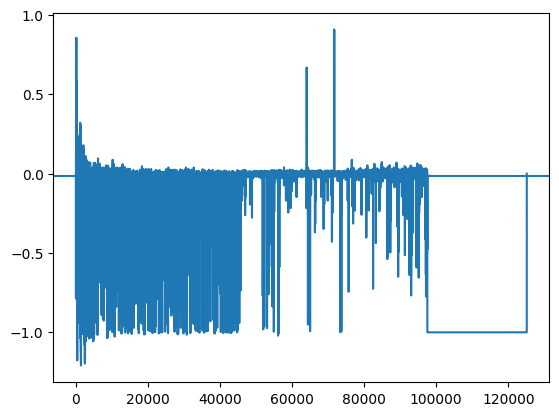

In [11]:
from matplotlib import pyplot as plt

plt.plot(smooth_abs)
plt.axhline(-rms_smooth_abs)
#plt.xlim(2000,2500)

In [10]:
rms_smooth_abs

0.013062501976221599